In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cluster import KMeans
%matplotlib inline

In [109]:
# load point cloud data

file = open('final_project_data/final_project_point_cloud.fuse', 'r')

data = []

for f in file:
    fs = f.split(" ")
    data.append([float(fs[0]), float(fs[1]), float(fs[2]), float(fs[3][:-1])])
    
file.close()

data = np.array(data)
x, y, z, intensity = data.T

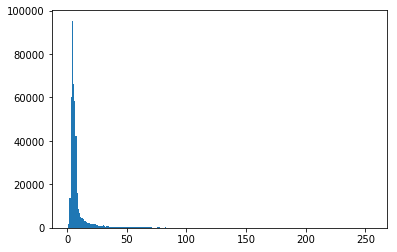

In [110]:
# analyzing the intensities

plt.hist(intensity, 255)
plt.show()

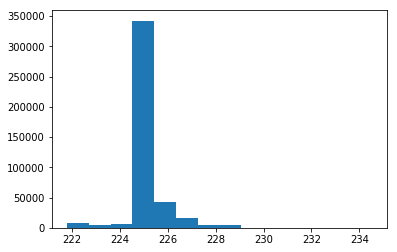

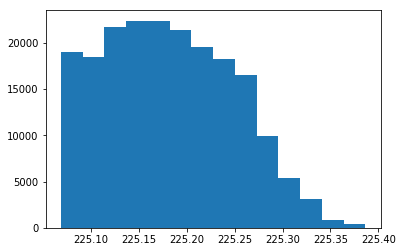

In [111]:
plt.hist(z, 14)
plt.show()
# altitude
z_range = max(z) - min(z)
min_alt = np.median(z) - 0.005 * z_range
max_alt = np.median(z) + 0.02 * z_range
road_data = []
for d in data:
    if d[2] >= min_alt and d[2] <= max_alt:
        road_data.append(d)
road_data = np.array(road_data)
road_x, road_y, road_z, r_intensity = road_data.T
plt.hist(road_z, 14)
plt.show()

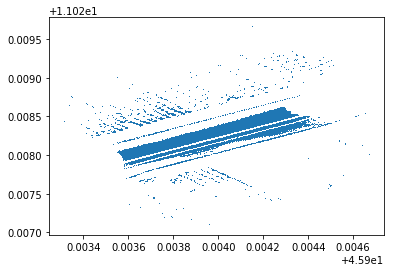

In [112]:
# plot the road based on latitude and longitude obtained using altitude calculation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(road_x, road_y, ',')
plt.show()

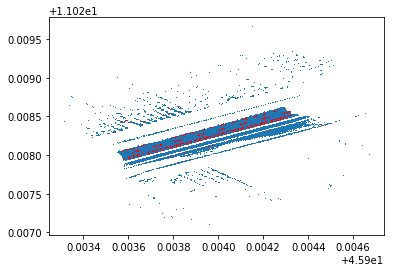

In [113]:
# Filtering out latitude and longitude based on intensity
lane_data = []
for d in road_data:
     if d[3] >= 70:
        lane_data.append(d[:-1])

lane_data = np.array(lane_data)
lane_x, lane_y, lane_z = lane_data.T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(road_x, road_y, ',')
ax.plot(lane_x, lane_y, ',', color='red')
plt.show()

In [114]:
# separate 3 lanes
kmeans = KMeans(max_iter=500000,n_clusters=3).fit(lane_data)
label = kmeans.labels_

line_1 = []
line_2 = []
line_3 = []
line_new = []
for i in range(len(label)):
    if label[i] == 0:
        line_1.append([lane_data[i][0],lane_data[i][1],lane_data[i][2]])
    elif label[i] == 1:
        line_2.append([lane_data[i][0],lane_data[i][1],lane_data[i][2]])
    elif label[i] == 2:
        line_3.append([lane_data[i][0],lane_data[i][1],lane_data[i][2]])
    else:
        line_new.append([x_new[i][0],x_new[i][1],x_new[i][2]])

line_1 = np.asarray(line_1)
line_2 = np.asarray(line_2)
line_3 = np.asarray(line_3)

if(len(line_1)!=0):
    rx1, ry1, rz1 = line_1.T
if(len(line_2)!=0):
    rx2, ry2, rz2 = line_2.T
if(len(line_3)!=0):
    rx3, ry3, rz3 = line_3.T
    
X_1 = line_1[:,0][:, np.newaxis]
y_1 = line_1[:,1]

X_2 = line_2[:,0][:, np.newaxis]
y_2 = line_2[:,1]

X_3 = line_3[:,0][:, np.newaxis]
y_3 = line_3[:,1]

<function matplotlib.pyplot.show>

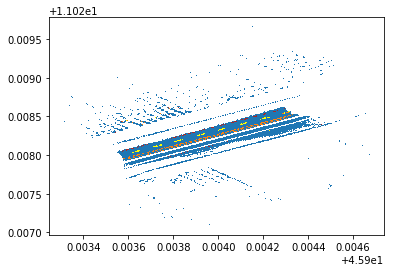

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(road_x, road_y, ',')
ax.plot(lane_x, lane_y, ',', color='red')
ax.plot(X_1, y_1, ',')
ax.plot(X_2, y_2, ',', color= 'brown')
ax.plot(X_3, y_3, ',', color= 'yellow')
plt.show

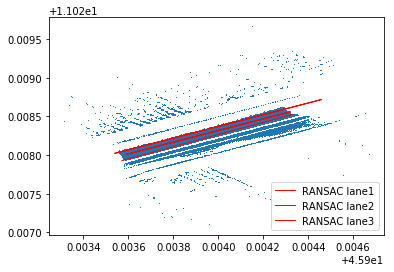

In [116]:
# use ransac to fit lanes

# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X_1, y_1)

model_2 = linear_model.LinearRegression()
model_2.fit(X_2, y_2)

model_3 = linear_model.LinearRegression()
model_3.fit(X_3, y_3)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X_1, y_1)

model_ransac_2 = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_2.fit(X_2, y_2)

model_ransac_3 = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_3.fit(X_3, y_3)

inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

inlier_mask_2 = model_ransac_2.inlier_mask_
outlier_mask_2 = np.logical_not(inlier_mask_2)

inlier_mask_3 = model_ransac_3.inlier_mask_
outlier_mask_3 = np.logical_not(inlier_mask_3)

# Predict data of estimated models
line_X = X_1
line_y = model.predict(X_1)
line_y_ransac = model_ransac.predict(X_1)

line_X_2 = X_2
line_y_2 = model_2.predict(X_2)
line_y_ransac_2 = model_ransac_2.predict(X_2)

line_X_3 = X_3
line_y_3 = model_3.predict(X_3)
line_y_ransac_3 = model_ransac_3.predict(X_3)



plt.plot(road_x, road_y, ',')

lw = 1
plt.plot(line_X, line_y_ransac, color='red', linestyle='-', linewidth=lw, label='RANSAC lane1')
plt.plot(line_X_2, line_y_ransac_2, color='red', linestyle='-',linewidth=lw, label='RANSAC lane2')
plt.plot(line_X_3, line_y_ransac_3, color='red', linestyle='-',linewidth=lw, label='RANSAC lane3')

plt.legend(loc='lower right')
plt.show()